In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import random
import math

# Convolutions

In today's lecture we shall look at convolutions. Convolution is an operator that takes two functions and creates a new function. For a more thorough discussion, see the [Wikipedia page](https://en.wikipedia.org/wiki/Convolution).

## The continuous case

The perhaps most common situation is the continuous case, when we have two functions $f,g:\mathbb{R} \rightarrow \mathbb{R}$; their convolution $f \ast g$ is then defined by:
$$
(f \ast g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t-\tau)\, d\tau.
$$
For this to be well defined there are some requirements on $f$ and $g$ (otherwise the integral might very well be infinite). We will not be dealing with the continuous case in this module.

It might not be completely obvious from the definition, but the convolution operator is in fact commutative, i.e. we have
$$
f \ast g = g \ast f,
$$
this can be seen by changing variables in the integration.

## The discrete case

The integral can be thought of as a generalisation of a sum, so it should not come as a surprise that we can define a discrete version of the convolution. We will start by looking at the 1-dimensional case.

### 1D convolution

Now we let $f$ and $g$ be functions $f,g : \mathbb{Z} \rightarrow \mathbb{R}$. Their convolution $f\star g : \mathbb{Z} \rightarrow \mathbb{R}$ is then defined by
$$
(f \ast g)(n) = \sum_{i = -\infty}^{+\infty} f(i)g(n-i).
$$
This convolution is also commutative.
There is functionality in NumPy for computing these 1D convolutions via the function `np.convolve(a, b)` where `a` and `b` are both 1D arrays.


#### An example: a noisy sin function
As an example we'll look at the $\sin$ function, but with an added noise to it. The noise will be coming from the `gauss` function from the `random` module, which generates normally distributed numbers with a given mean and standard deviation.

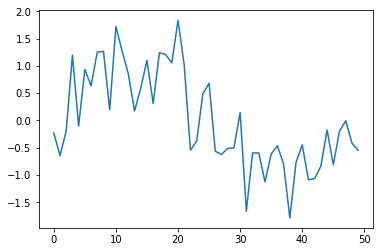

In [3]:
# an example with a noisy sin function
# (I'm using a list comprehension to create the data from which the array is created.))
data = np.array([math.sin(2*i*math.pi/50) + random.gauss(0,0.5) for i in range(50)])
plt.plot(range(50),list(data)) # plot() expects a list of x-values and a list of y-values
plt.show()

We see that the graph of resulting curve is rather jagged.

We can now take a rolling average of the original value and its ten closest neighbours to attempt to smoothen the curve.

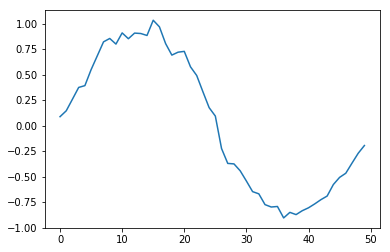

In [4]:
win_size = 11
plt.plot(range(50), np.convolve(data, [1/win_size]*win_size, 'same'))
# 'same' means that we that the length of the convolved data array is the same as the original array.
# There are boundary conditions that have to be considered, and this is one of the ways to deal with them.
plt.show()

Instead of having a vector with the same number repeated a given number of times, we can let closer points be weighted higher than points further away.

In [5]:
v = np.array([math.exp(-(((i-5))**2/16)) for i in range(11)])
print(v)
# v is an array where the values decay exponentially with the distance from the middle element
# which is the element with index five in this case. (0,1,2,3,4 to the left, 6, 7, 8, 9, 10) to the right.

# we make sure that the sum of the entries in the kernel are 1, otherwise we won't get an average,
# which is what we want.
kernel = v/sum(v)
print(kernel)


[0.20961139 0.36787944 0.56978282 0.77880078 0.93941306 1.
 0.93941306 0.77880078 0.56978282 0.36787944 0.20961139]
[0.03114131 0.0546547  0.08465086 0.11570401 0.13956567 0.14856689
 0.13956567 0.11570401 0.08465086 0.0546547  0.03114131]


We can now see that we get an even smoother curve.

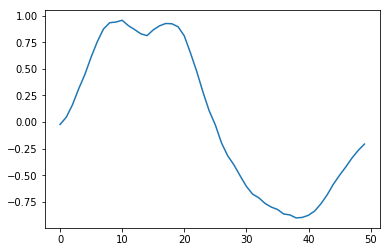

In [6]:
plt.plot(range(50), np.convolve(data, kernel, 'same'))
plt.show()

Let's plot all the curves together. The blue is the original, the orange is the plain average and the green is with the Gaussian kernel.

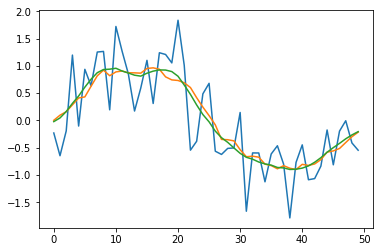

In [7]:
plt.plot(range(50),list(data))
plt.plot(range(50), np.convolve(data, [0.1]*10, 'same'))
plt.plot(range(50), np.convolve(data, kernel, 'same'))
plt.show()

### 2D convolution

Next up we'll look at convolutions of functions of two variables. The use case for us is pixels in images, so we will only deal with the discrete case. (One could ask why not using a 3D convolution, given that our image data is actually 3-dimensional, with the colour along the third axis, but we will let nearby pixels influence each other, but not "nearby colours" influence each other, so a 2-dimensional convolution is what we need).

Here we let $f$ and $g$ be functions $f,g : \mathbb{Z}^2 \rightarrow \mathbb{R}$, and define their convolution to be
$$
(f\ast g)(m,n) = \sum_{i=-\infty}^{+\infty} \sum_{j=-\infty}^{+\infty} f(i,j)g(m-i,n-j)
$$
Unfortunately, there is no built-in functionality for 2D convolutions in NumPy, so we'll have to implement it ourselves.

#### An example image

Let's generate an image of size 100 by 100 pixels, with two circles drawn on it. The low resolution is intentional, because it allows us to better see the blurring effect of applying a convolution.

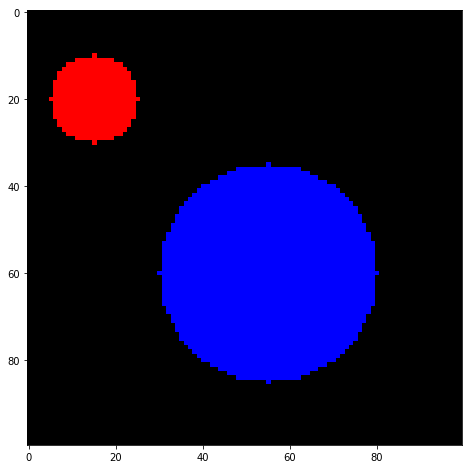

In [8]:
expic = np.zeros((100,100,3),dtype='uint8')
for i in range(expic.shape[0]):
    for j in range(expic.shape[1]):
        if (i-20)**2 + (j-15)**2 <= 10**2:
            # a red circle with centre (20,15) and radius 10
            expic[i,j,0]=255
        if (i-60)**2 + (j-55)**2 <= 25**2:
            # a blue circle with centre (60,55) and radius 25
            expic[i,j,2] = 255

plt.figure(figsize=(8,8))
plt.imshow(expic)

We can zoom in a bit as well

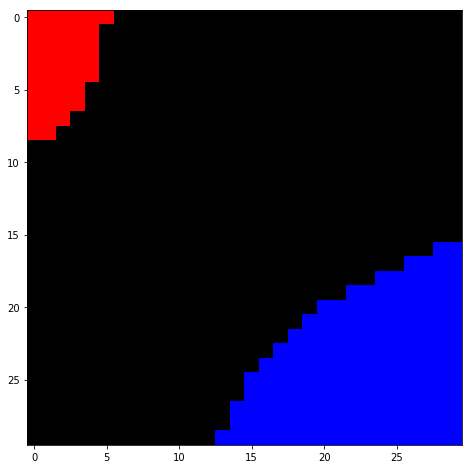

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(expic[20:50,20:50,:])

We can see that the image is rather blocky, so we might want to smoothen the circles by blurring.
To this end, we will convolve the image with a $3 \times 3$ matrix in such a way that the intensity of a pixel will be the average of the  original intensity in the pixel and that of its neighbouring pixels.

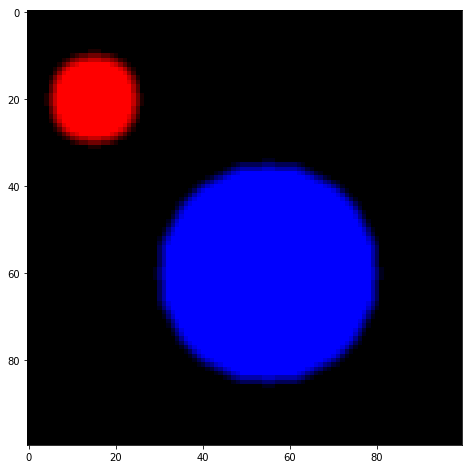

In [10]:
# Blur with an averaging kernel
kernel = np.ones((3,3))/9
#print(kernel)

avblur = np.zeros((100,100,3), dtype='uint8')
for r in range(1,99):
    for c in range(1,99):
        val = np.array([0,0,0])
        for i in range(3):
            for j in range(3):
                val = val + kernel[i, j]*expic[r-i+1, c-j+1]
        avblur[r,c,:] = np.uint8(val)

        
plt.figure(figsize=(8,8))
plt.imshow(avblur)
#print(avblur[20:25,20:25,0])             

Let's zoom in here as well in the same way as on our original.

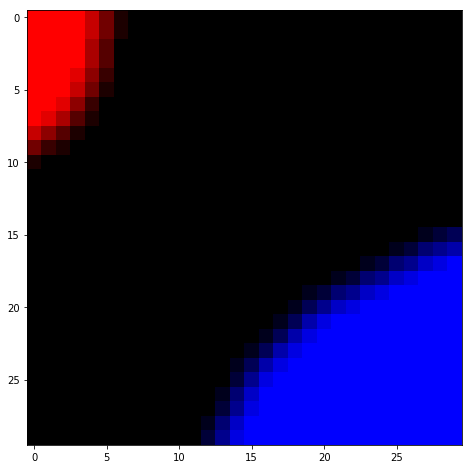

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(avblur[20:50,20:50,:])

#### Blurring with a Gaussian kernel

We saw earlier that we might get even better results by having a Gaussian kernel for the convolution, so let's create one now.

In [12]:
# the entries in the matrix should decay exponentially with the distance from the
# entry "in the middle", i.e. the one with index (1,1)
v = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        v[i,j] = math.exp(-((i-1)**2+(j-1)**2)/2)
        
# as before, we want an average, so the sum of the weights should be one.
gauss_kernel = v/sum(v)
print(gauss_kernel)

[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


We can now compute the blurring

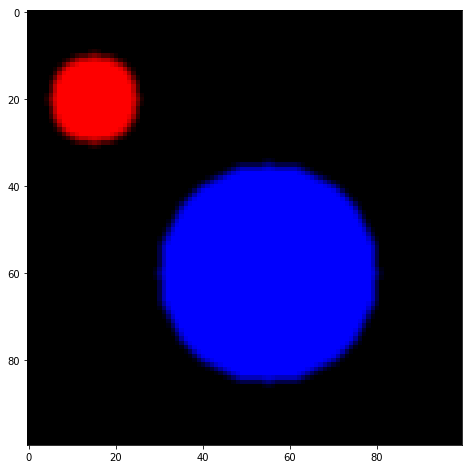

In [13]:
gaussblur = np.zeros((100,100,3), dtype='uint8')
for r in range(1,99):
    for c in range(1,99):
        val = np.array([0,0,0])
        for i in range(3):
            for j in range(3):
                val = val + gauss_kernel[i, j]*expic[r-i+1, c-j+1]
        gaussblur[r,c,:] = np.uint8(val)

       
plt.figure(figsize=(8,8))
plt.imshow(gaussblur)
#print(avblur[20:25,20:25,0])             

And zoom in again. The difference is not huge to the average blur, but it's clearly there.

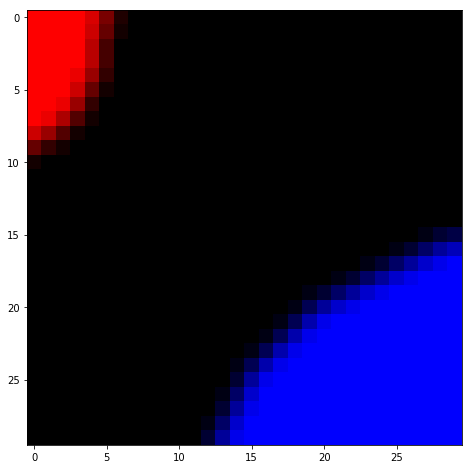

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(gaussblur[20:50,20:50,:])